#### Initial settings

In [1]:
#-- Import general libraries
import os
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices' ## enable xla devices # Comment out this line if runing on GPU cluster
import numpy as np 
import pandas as pd
import time 
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import wandb

/home/dg321/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{0}"

In [3]:
# Check if GPU is available 
is_gpu = torch.cuda.is_available()
device = torch.device("cuda" if is_gpu else "cpu")
print(f"Is GPU available? {is_gpu}")

# If GPU is available, print additional information
if is_gpu:
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print(f"GPU Device Name: {device_name}")
    print(f"GPU Device Index: {current_device}")

Is GPU available? True
GPU Device Name: GeForce RTX 2080 Ti
GPU Device Index: 0


#### Functions

In [4]:
def plot_3d_tensor(tensor, alpha = 0.15, title='3D Tensor'):
    # Create a 3D plot
    fig = plt.figure(figsize=(15, 10))

    x_size, y_size, z_size = tensor.size()

    # Create a grid of coordinates
    x, y, z = np.meshgrid(np.arange(x_size), np.arange(y_size), np.arange(z_size))

    # Plot at t = 0
    ax = fig.add_subplot(221, projection='3d')
    ax.scatter(x, y, z, c=tensor.cpu().detach().numpy().flatten(), cmap='viridis', alpha=alpha)
    ax.set_title(title)

    # Plot the 2D profile along the x-axis at the center of the grid
    ax = fig.add_subplot(222)
    im = ax.imshow(tensor.cpu().detach().numpy()[x_size//2, :, :], cmap='viridis')
    ax.set_title('2D Profile along X-axis')
    fig.colorbar(im, ax=ax)

    # Plot the 2D profile along the y-axis at the center of the grid
    ax = fig.add_subplot(223)
    im = ax.imshow(tensor.cpu().detach().numpy()[:, y_size//2, :], cmap='viridis')
    ax.set_title('2D Profile along Y-axis')
    fig.colorbar(im, ax=ax)

    # Plot the 2D profile along the z-axis at the center of the grid
    ax = fig.add_subplot(224)
    im = ax.imshow(tensor.cpu().detach().numpy()[:, :, z_size//2], cmap='viridis')
    ax.set_title('2D Profile along Z-axis')
    fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()

#### Filters

In [5]:
# # # ################################### # # #
# # # ######   Numerial parameters ###### # # #
# # # ################################### # # #
c = 1  # speed of sound 1m/s
courant_number = 0.1

# # # ################################### # # #
# # # ######    Linear Filter      ###### # # #
# # # ################################### # # #

filter = torch.tensor([[[0.0, 0.0, 0.0],
                        [-1.0, 0.0, -1.0],
                        [0.0, 0.0, 0.0]],
                       [[-1.0, 0.0, -1.0],
                        [4.0, 0.0, 4.0],
                        [-1.0, 0.0, -1.0]],
                       [[0.0, 0.0, 0.0],
                        [-1.0, 0.0, -1.0],
                        [0.0, 0.0, 0.0]]])

advection_operator_x = torch.tensor([[[0.0, 0.0, 0.0],
                                      [0.0, 0.0, 0.0],
                                      [0.0, 0.0, 0.0]],
                                     [[0.5, 0.0, -0.5],
                                      [0.0, 0.0, 0.0],
                                      [0.5, 0.0, -0.5]],
                                     [[0.0, 0.0, 0.0],
                                      [0.0, 0.0, 0.0],
                                      [0.0, 0.0, 0.0]]])

advection_operator_y = torch.tensor([[[0.0, 0.0, 0.0],
                                      [-0.5, 0.0, 0.5],
                                      [0.0, 0.0, 0.0]],
                                     [[0.0, 0.0, 0.0],
                                      [0.0, 0.0, 0.0],
                                      [0.0, 0.0, 0.0]],
                                     [[0.0, 0.0, 0.0],
                                      [-0.5, 0.0, 0.5],
                                      [0.0, 0.0, 0.0]]])

print(filter)
print(filter.shape)

tensor([[[ 0.,  0.,  0.],
         [-1.,  0., -1.],
         [ 0.,  0.,  0.]],

        [[-1.,  0., -1.],
         [ 4.,  0.,  4.],
         [-1.,  0., -1.]],

        [[ 0.,  0.,  0.],
         [-1.,  0., -1.],
         [ 0.,  0.,  0.]]])
torch.Size([3, 3, 3])


##### 7 * 7 * 7 Cubic

In [6]:
# 7*7*7
data_str = """-3.0233027301446538E-005   1.6010040368539302E-004  -6.4737846719575170E-004  -7.4713521719849997E-004  -6.4737846719575181E-004   1.6010040368539307E-004  -3.0233027301446548E-005
 1.6010040368539299E-004  -7.7924291122586286E-004   2.7336119626842990E-003   6.5505880283367691E-003   2.7336119626842994E-003  -7.7924291122586319E-004   1.6010040368539304E-004
-6.4737846719575170E-004   2.7336119626842994E-003  -6.8265505662681806E-003  -4.2274082545691781E-002  -6.8265505662681797E-003   2.7336119626842994E-003  -6.4737846719575170E-004
-7.4713521719849965E-004   6.5505880283367700E-003  -4.2274082545691774E-002   7.9665837184500585E-002  -4.2274082545691802E-002   6.5505880283367734E-003  -7.4713521719850051E-004
-6.4737846719575191E-004   2.7336119626843011E-003  -6.8265505662681823E-003  -4.2274082545691774E-002  -6.8265505662681823E-003   2.7336119626843011E-003  -6.4737846719575181E-004
 1.6010040368539307E-004  -7.7924291122586351E-004   2.7336119626843003E-003   6.5505880283367717E-003   2.7336119626843003E-003  -7.7924291122586308E-004   1.6010040368539307E-004
-3.0233027301446555E-005   1.6010040368539310E-004  -6.4737846719575181E-004  -7.4713521719850051E-004  -6.4737846719575181E-004   1.6010040368539310E-004  -3.0233027301446555E-005
 1.6010040368539299E-004  -7.7924291122586286E-004   2.7336119626842990E-003   6.5505880283367752E-003   2.7336119626842990E-003  -7.7924291122586286E-004   1.6010040368539302E-004
-7.7924291122586254E-004   3.6067814748168515E-003  -1.1421474670253369E-002  -3.8917617394937362E-002  -1.1421474670253366E-002   3.6067814748168524E-003  -7.7924291122586265E-004
 2.7336119626842998E-003  -1.1421474670253369E-002   2.7595635346385174E-002  0.18309982005489983        2.7595635346385171E-002  -1.1421474670253368E-002   2.7336119626842994E-003
 6.5505880283367717E-003  -3.8917617394937355E-002  0.18309982005489986        1.9196587273369037E-003  0.18309982005489989       -3.8917617394937369E-002   6.5505880283367752E-003
 2.7336119626842998E-003  -1.1421474670253371E-002   2.7595635346385195E-002  0.18309982005489983        2.7595635346385185E-002  -1.1421474670253373E-002   2.7336119626842998E-003
-7.7924291122586286E-004   3.6067814748168532E-003  -1.1421474670253371E-002  -3.8917617394937355E-002  -1.1421474670253369E-002   3.6067814748168532E-003  -7.7924291122586297E-004
 1.6010040368539299E-004  -7.7924291122586286E-004   2.7336119626842994E-003   6.5505880283367752E-003   2.7336119626843007E-003  -7.7924291122586308E-004   1.6010040368539307E-004
-6.4737846719575159E-004   2.7336119626842990E-003  -6.8265505662681719E-003  -4.2274082545691767E-002  -6.8265505662681745E-003   2.7336119626842990E-003  -6.4737846719575170E-004
 2.7336119626842985E-003  -1.1421474670253361E-002   2.7595635346385164E-002  0.18309982005489983        2.7595635346385178E-002  -1.1421474670253364E-002   2.7336119626842998E-003
-6.8265505662681754E-003   2.7595635346385185E-002  -5.9525983324614049E-002 -0.49230758174491834       -5.9525983324614021E-002   2.7595635346385178E-002  -6.8265505662681754E-003
-4.2274082545691760E-002  0.18309982005489980      -0.49230758174491818       -2.5867401350870951      -0.49230758174491829       0.18309982005489983       -4.2274082545691767E-002
-6.8265505662681745E-003   2.7595635346385185E-002  -5.9525983324614049E-002 -0.49230758174491840       -5.9525983324614062E-002   2.7595635346385178E-002  -6.8265505662681780E-003
 2.7336119626842990E-003  -1.1421474670253364E-002   2.7595635346385171E-002  0.18309982005489980        2.7595635346385192E-002  -1.1421474670253368E-002   2.7336119626842998E-003
-6.4737846719575159E-004   2.7336119626842990E-003  -6.8265505662681754E-003  -4.2274082545691774E-002  -6.8265505662681771E-003   2.7336119626842998E-003  -6.4737846719575170E-004
-7.4713521719850095E-004   6.5505880283367795E-003  -4.2274082545691795E-002   7.9665837184500599E-002  -4.2274082545691802E-002   6.5505880283367787E-003  -7.4713521719850095E-004
 6.5505880283367787E-003  -3.8917617394937390E-002  0.18309982005490000        1.9196587273369037E-003  0.18309982005489994       -3.8917617394937404E-002   6.5505880283367787E-003
-4.2274082545691795E-002  0.18309982005489994      -0.49230758174491840       -2.5867401350870960      -0.49230758174491862       0.18309982005489994       -4.2274082545691795E-002
 7.9665837184500571E-002   1.9196587273371257E-003  -2.5867401350870960        18.000000000000000       -2.5867401350870960        1.9196587273371257E-003   7.9665837184500571E-002
-4.2274082545691795E-002  0.18309982005489997      -0.49230758174491840       -2.5867401350870960      -0.49230758174491840       0.18309982005489994       -4.2274082545691781E-002
 6.5505880283367787E-003  -3.8917617394937404E-002  0.18309982005489997        1.9196587273369592E-003  0.18309982005489997       -3.8917617394937397E-002   6.5505880283367804E-003
-7.4713521719850095E-004   6.5505880283367787E-003  -4.2274082545691802E-002   7.9665837184500599E-002  -4.2274082545691809E-002   6.5505880283367795E-003  -7.4713521719850095E-004
-6.4737846719575170E-004   2.7336119626842998E-003  -6.8265505662681771E-003  -4.2274082545691774E-002  -6.8265505662681745E-003   2.7336119626842990E-003  -6.4737846719575159E-004
 2.7336119626842998E-003  -1.1421474670253368E-002   2.7595635346385188E-002  0.18309982005489978        2.7595635346385171E-002  -1.1421474670253364E-002   2.7336119626842994E-003
-6.8265505662681771E-003   2.7595635346385178E-002  -5.9525983324614076E-002 -0.49230758174491823       -5.9525983324614049E-002   2.7595635346385178E-002  -6.8265505662681754E-003
-4.2274082545691774E-002  0.18309982005489983      -0.49230758174491834       -2.5867401350870947      -0.49230758174491823       0.18309982005489978       -4.2274082545691767E-002
-6.8265505662681754E-003   2.7595635346385178E-002  -5.9525983324614035E-002 -0.49230758174491823       -5.9525983324614055E-002   2.7595635346385178E-002  -6.8265505662681754E-003
 2.7336119626842998E-003  -1.1421474670253364E-002   2.7595635346385174E-002  0.18309982005489978        2.7595635346385171E-002  -1.1421474670253362E-002   2.7336119626842990E-003
-6.4737846719575170E-004   2.7336119626842990E-003  -6.8265505662681745E-003  -4.2274082545691767E-002  -6.8265505662681719E-003   2.7336119626842981E-003  -6.4737846719575159E-004
 1.6010040368539307E-004  -7.7924291122586308E-004   2.7336119626843007E-003   6.5505880283367761E-003   2.7336119626842998E-003  -7.7924291122586286E-004   1.6010040368539299E-004
-7.7924291122586297E-004   3.6067814748168528E-003  -1.1421474670253369E-002  -3.8917617394937362E-002  -1.1421474670253371E-002   3.6067814748168532E-003  -7.7924291122586286E-004
 2.7336119626842998E-003  -1.1421474670253375E-002   2.7595635346385181E-002  0.18309982005489983        2.7595635346385195E-002  -1.1421474670253371E-002   2.7336119626842998E-003
 6.5505880283367752E-003  -3.8917617394937362E-002  0.18309982005489991        1.9196587273367927E-003  0.18309982005489991       -3.8917617394937348E-002   6.5505880283367717E-003
 2.7336119626842994E-003  -1.1421474670253368E-002   2.7595635346385167E-002  0.18309982005489980        2.7595635346385178E-002  -1.1421474670253369E-002   2.7336119626842994E-003
-7.7924291122586265E-004   3.6067814748168524E-003  -1.1421474670253369E-002  -3.8917617394937355E-002  -1.1421474670253368E-002   3.6067814748168515E-003  -7.7924291122586254E-004
 1.6010040368539302E-004  -7.7924291122586286E-004   2.7336119626842990E-003   6.5505880283367752E-003   2.7336119626842990E-003  -7.7924291122586286E-004   1.6010040368539299E-004
-3.0233027301446555E-005   1.6010040368539310E-004  -6.4737846719575181E-004  -7.4713521719850051E-004  -6.4737846719575181E-004   1.6010040368539310E-004  -3.0233027301446555E-005
 1.6010040368539307E-004  -7.7924291122586308E-004   2.7336119626843003E-003   6.5505880283367717E-003   2.7336119626843003E-003  -7.7924291122586351E-004   1.6010040368539307E-004
-6.4737846719575181E-004   2.7336119626843007E-003  -6.8265505662681806E-003  -4.2274082545691774E-002  -6.8265505662681815E-003   2.7336119626843011E-003  -6.4737846719575191E-004
-7.4713521719850051E-004   6.5505880283367734E-003  -4.2274082545691802E-002   7.9665837184500585E-002  -4.2274082545691781E-002   6.5505880283367700E-003  -7.4713521719849965E-004
-6.4737846719575170E-004   2.7336119626842994E-003  -6.8265505662681797E-003  -4.2274082545691781E-002  -6.8265505662681797E-003   2.7336119626842998E-003  -6.4737846719575170E-004
 1.6010040368539304E-004  -7.7924291122586319E-004   2.7336119626842994E-003   6.5505880283367700E-003   2.7336119626842994E-003  -7.7924291122586286E-004   1.6010040368539299E-004
-3.0233027301446548E-005   1.6010040368539307E-004  -6.4737846719575170E-004  -7.4713521719849997E-004  -6.4737846719575170E-004   1.6010040368539302E-004  -3.0233027301446538E-005"""

# Convert the string to a 2D NumPy array
data_array = np.array([list(map(float, line.split())) for line in data_str.split('\n')])

# Reshape the array into a 7x7x1 tensor
tensor = data_array.reshape(7, 7, 7)


# Convert the 3D tensor to a PyTorch tensor
filter = torch.FloatTensor(tensor)

print(filter.shape)

torch.Size([7, 7, 7])


#### New initial conditions - Gaussian Distribution

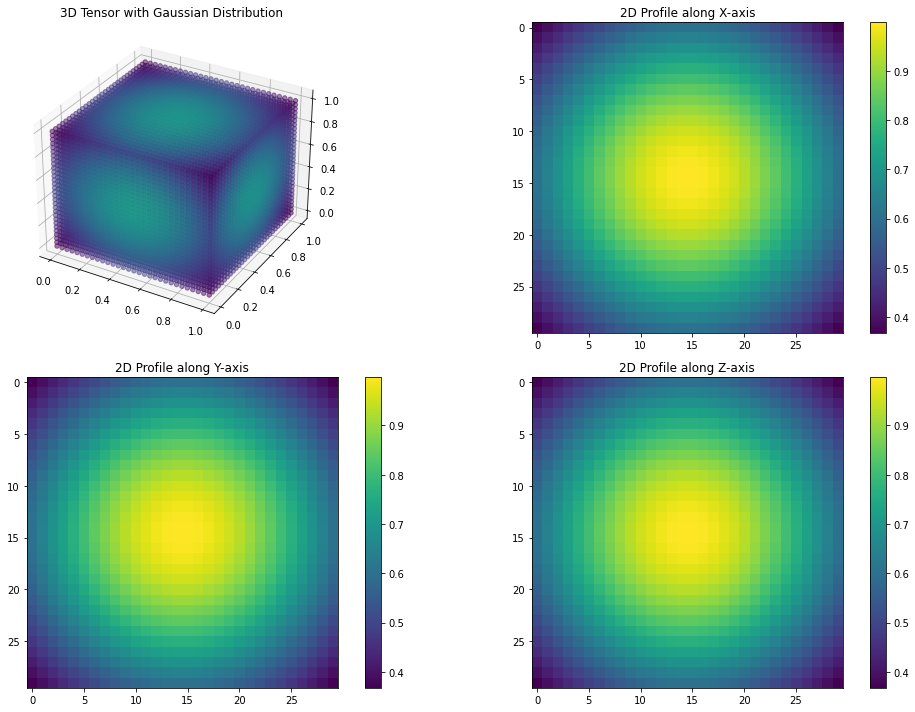

In [8]:
from mpl_toolkits.mplot3d import Axes3D

# Specify the size of the tensor
x_size = y_size = z_size = 30

# Create a 3D meshgrid
x_values = np.linspace(0, 1, x_size)
y_values = np.linspace(0, 1, y_size)
z_values = np.linspace(0, 1, z_size)
x, y, z = np.meshgrid(x_values, y_values, z_values)

# Convert NumPy arrays to PyTorch tensors with float type
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)
z_tensor = torch.tensor(z, dtype=torch.float32)

# Function to create 3D Gaussian distribution
def gaussian3d(x, y, z, mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z):
    exponent = -((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2) + (z - mu_z)**2 / (2 * sigma_z**2))
    return torch.exp(exponent)

# Parameters for Gaussian distributions
mu_x = 0.5
mu_y = 0.5
mu_z = 0.5
sigma_x = 0.5
sigma_y = 0.5
sigma_z = 0.5

# Evaluate the Gaussian distribution
t0_values = gaussian3d(x_tensor, y_tensor, z_tensor, mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z)

# Create a 3D plot
fig = plt.figure(figsize=(15, 10))

# Plot at t = 0
ax = fig.add_subplot(221, projection='3d')
ax.scatter(x, y, z, c=t0_values.numpy().flatten(), cmap='viridis', alpha=0.5)
ax.set_title('3D Tensor with Gaussian Distribution')

# Plot the 2D profile along the x-axis at the center of the grid
ax = fig.add_subplot(222)
im = ax.imshow(t0_values[x_size//2, :, :].numpy(), cmap='viridis')
ax.set_title('2D Profile along X-axis')
fig.colorbar(im, ax=ax)

# Plot the 2D profile along the y-axis at the center of the grid
ax = fig.add_subplot(223)
im = ax.imshow(t0_values[:, y_size//2, :].numpy(), cmap='viridis')
ax.set_title('2D Profile along Y-axis')
fig.colorbar(im, ax=ax)

# Plot the 2D profile along the z-axis at the center of the grid
ax = fig.add_subplot(224)
im = ax.imshow(t0_values[:, :, z_size//2].numpy(), cmap='viridis')
ax.set_title('2D Profile along Z-axis')
fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

### Define NN Model

#### one time step - skipping layers

In [10]:
class AI4WaveNeuralNetwork_One_Skipping_3D(nn.Module):
    def __init__(self, x_size, y_size, z_size, filter_weight):
        super(AI4WaveNeuralNetwork_One_Skipping_3D, self).__init__()

        # Specify the size of the input (batch_size, channels, depth, height, width)
        in_channels = 1

        # Specify the size of the filter/kernel
        kernel_size = filter_weight.shape[2]
        padding = (kernel_size - 1) // 2

        # Create a Conv3d layer with the specified weight, input size, and padding
        self.conv_layer = nn.Conv3d(in_channels, out_channels=1, kernel_size=kernel_size, padding=padding, bias=False)
        self.conv_layer.weight.data = filter_weight

        self.x_size = x_size
        self.y_size = y_size
        self.z_size = z_size

    def forward(self, status_tn, status_tn_1, c_value):
        output_list = [status_tn]

        c = torch.ones((self.x_size, self.y_size, self.z_size), device=device) * c_value
        # c = torch.zeros((self.x_size, self.y_size, self.z_size), device=device)
        # for i in range(c_value.shape[0]):
        #     ones = torch.zeros((self.x_size, self.y_size, self.z_size), device=device)
        #     ones[:, :, i*int(self.x_size/c_value.shape[0]):(i+1)*int(self.x_size/c_value.shape[0])] = 1
        #     c += ones * c_value[i]

        # Calculate status_tn1 based on the provided expression
        c_status_tn = c * status_tn
        conv_term = self.conv_layer(c_status_tn.view(1, self.x_size, self.y_size, self.z_size)) + c * self.conv_layer(status_tn) - status_tn * self.conv_layer(c.view(1, self.x_size, self.y_size, self.z_size))
        
        status_tn1 = (2 * status_tn - status_tn_1) - (conv_term) * (0.1 * 0.1) / 2
        
        output_list.append(status_tn1)

        output_stacked = torch.cat(output_list, dim=1)

        return output_stacked

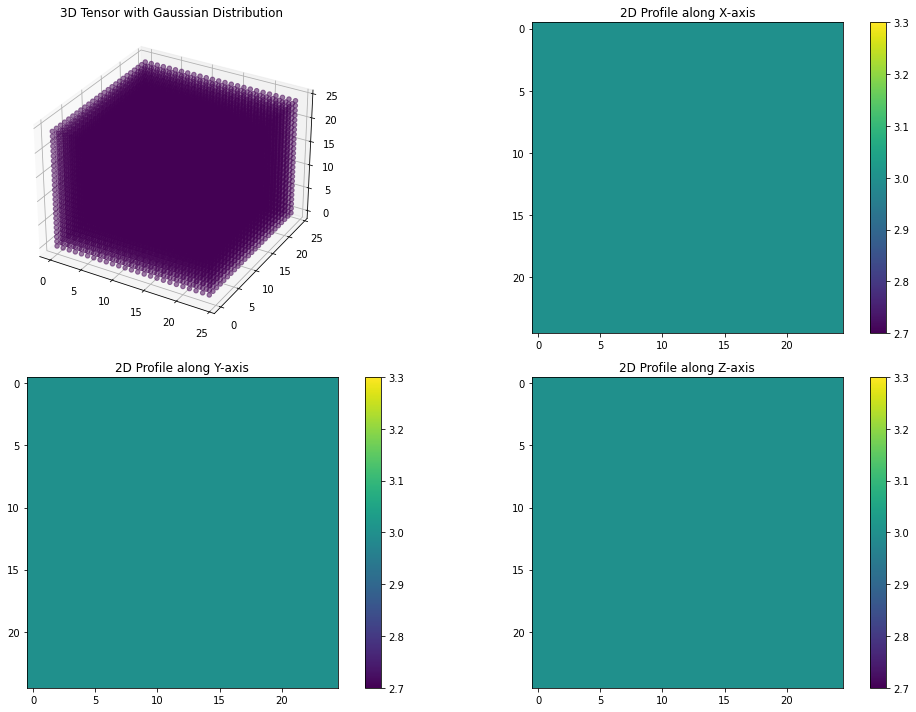

In [11]:
a = 0.5  # lower bound
b = 3  # upper bound
vec = a + (b - a) * torch.rand(5, requires_grad=True, dtype=torch.float32, device=device)

c = torch.ones((25, 25, 25), device='cuda:0', dtype=torch.float32) * 3.0
# # Create a 3D tensor
# c = torch.zeros((25, 25, 25), device='cuda:0', dtype=torch.float32)

# for i in range(5):
#     ones = torch.zeros((25, 25, 25), device='cuda:0', dtype=torch.float32)
#     ones[:,:,i*5:(i+1)*5] = 1
#     c += ones * vec[i]


# Create a 3D plot
fig = plt.figure(figsize=(15, 10))

# Create a grid of coordinates
x, y, z = np.meshgrid(np.arange(25), np.arange(25), np.arange(25))

# Plot at t = 0
ax = fig.add_subplot(221, projection='3d')
ax.scatter(x, y, z, c=c.cpu().detach().numpy().flatten(), cmap='viridis', alpha=0.5)
ax.set_title('3D Tensor with Gaussian Distribution')

# Plot the 2D profile along the x-axis at the center of the grid
ax = fig.add_subplot(222)
im = ax.imshow(c.cpu().detach().numpy()[25//2, :, :], cmap='viridis')
ax.set_title('2D Profile along X-axis')
fig.colorbar(im, ax=ax)

# Plot the 2D profile along the y-axis at the center of the grid
ax = fig.add_subplot(223)
im = ax.imshow(c.cpu().detach().numpy()[:, 25//2, :], cmap='viridis')
ax.set_title('2D Profile along Y-axis')
fig.colorbar(im, ax=ax)

# Plot the 2D profile along the z-axis at the center of the grid
ax = fig.add_subplot(224)
im = ax.imshow(c.cpu().detach().numpy()[:, :, c.shape[2]//2], cmap='viridis')  # Change here
ax.set_title('2D Profile along Z-axis')
fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

### Data assimilation one timestep - skipping layers

#### Generate Obs

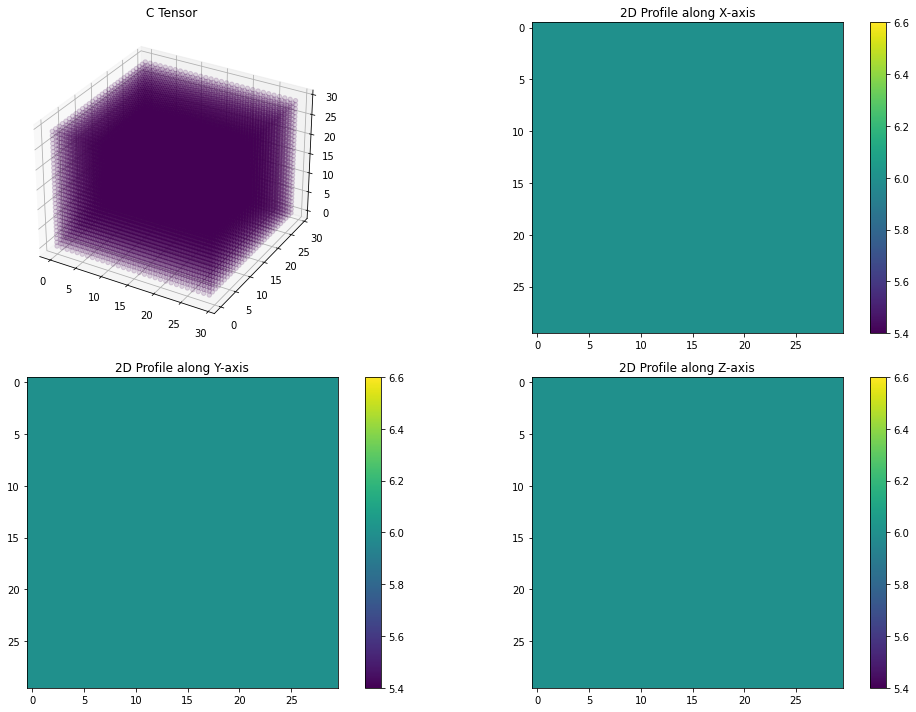

torch.Size([152, 30, 30, 30])


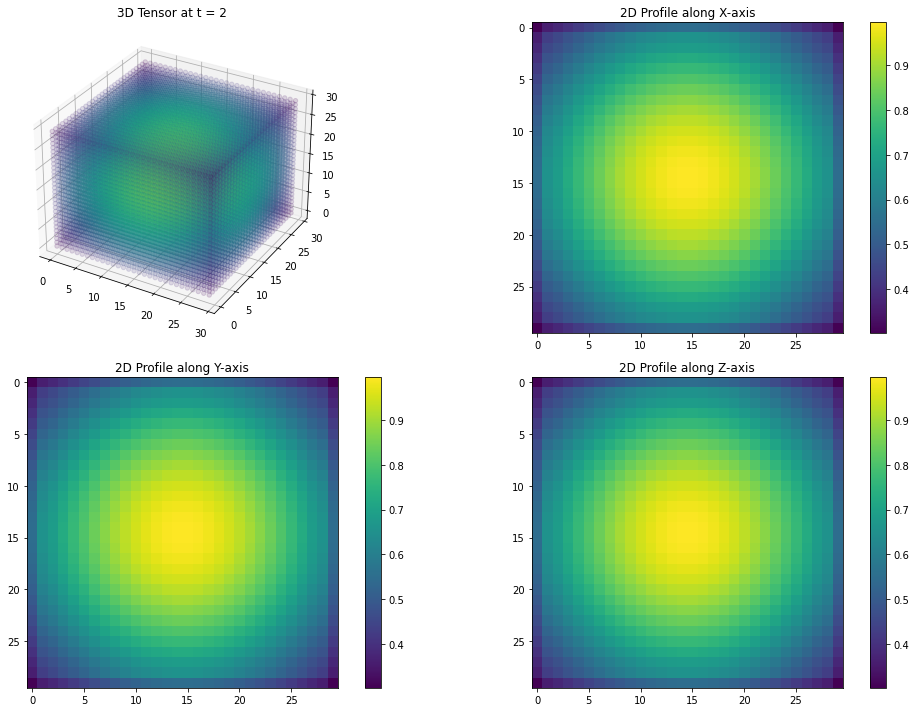

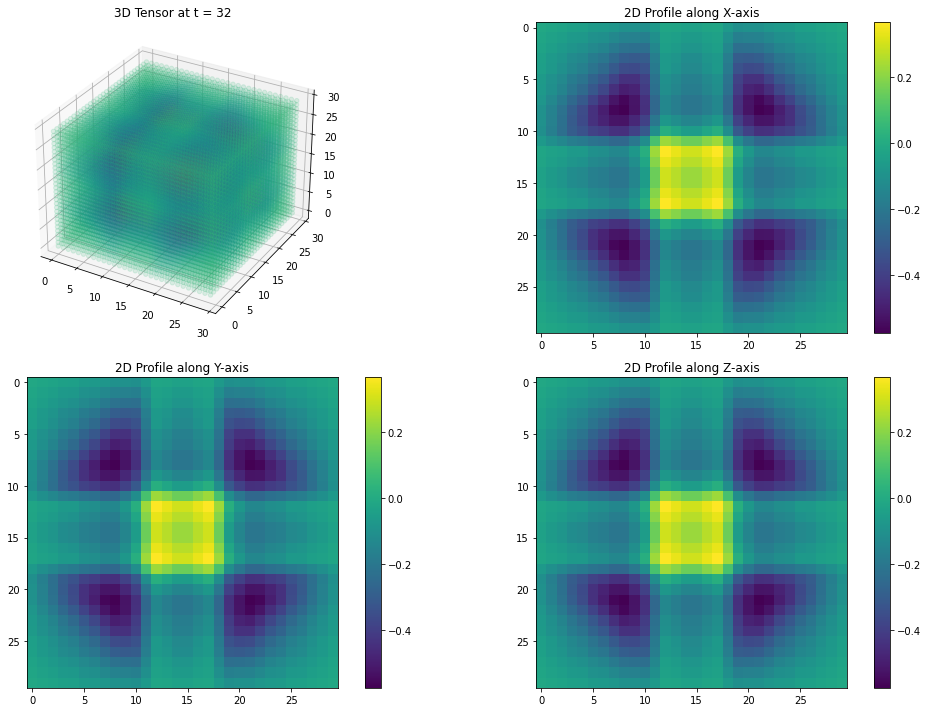

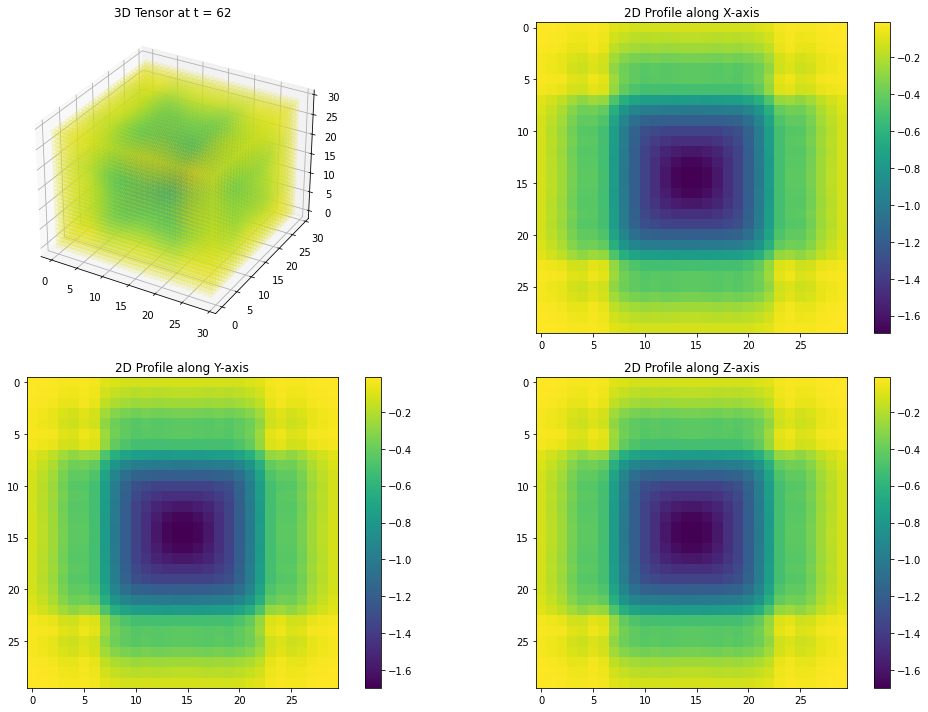

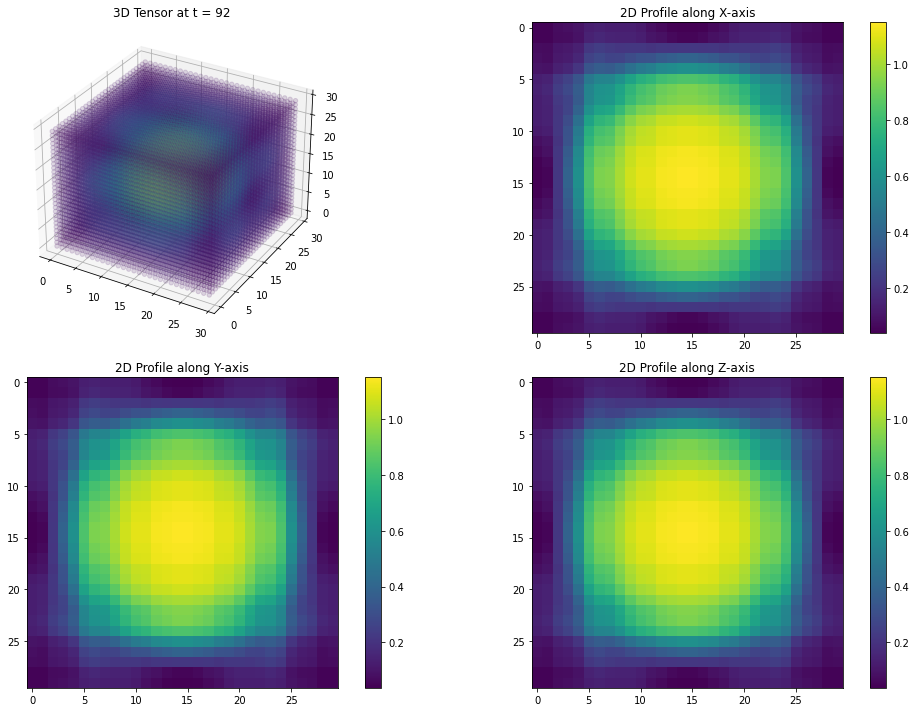

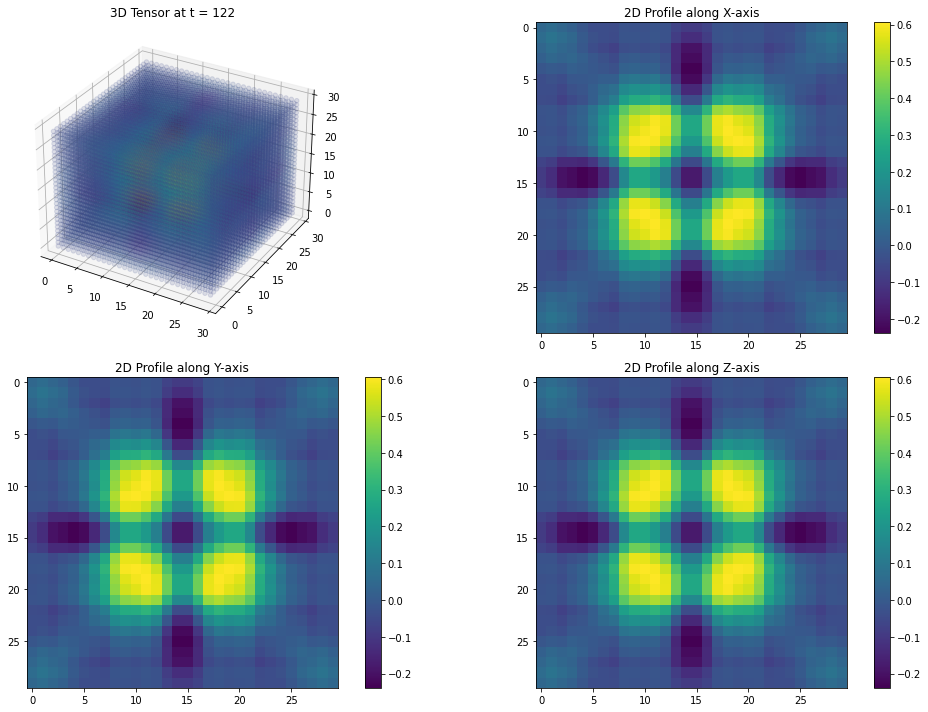

In [12]:
timesteps = 150

# Specify the size of the tensor
xsize = 30
ysize = 30
zsize = 30
mu_x = 0.5  # 0.2
mu_y = 0.5  # 0.2
mu_z = 0.5  # 0.2

# C values
# C_values_list = [5, 5, 5, 5, 5]  # [10, 6, 7, 8, 9]
# c_tensor = torch.tensor(C_values_list, dtype=torch.float32, device=device, requires_grad=True)

c_tensor = 6.0
c = torch.ones((xsize, ysize, zsize), device='cuda:0', dtype=torch.float32) * c_tensor


# Plot C
# nlayers = c_tensor.size(0)
# c = torch.zeros((xsize, ysize, zsize), device=device, dtype=torch.float32)

# for i in range(nlayers):
#     ones = torch.zeros((xsize, ysize, zsize), device=device, dtype=torch.float32)
#     ones[i*int(xsize/nlayers):(i+1)*int(xsize/nlayers)] = 1
#     c += ones * c_tensor[i]

plot_3d_tensor(c, title='C Tensor')


# Create a 3D meshgrid
x_values = np.linspace(0, 1, xsize)
y_values = np.linspace(0, 1, ysize)
z_values = np.linspace(0, 1, zsize)
x, y, z = np.meshgrid(x_values, y_values, z_values)

# Convert NumPy arrays to PyTorch tensors with float type
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)
z_tensor = torch.tensor(z, dtype=torch.float32)

# Function to create 3D Gaussian distribution
def gaussian3d(x, y, z, mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z):
    exponent = -((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2) + (z - mu_z)**2 / (2 * sigma_z**2))
    return torch.exp(exponent)

# Parameters for Gaussian distributions
sigma_x = 0.5
sigma_y = 0.5
sigma_z = 0.5

# Evaluate the Gaussian distributions at t = 0, 1, and 2
t0_values = gaussian3d(x_tensor, y_tensor, z_tensor, mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z)
t1_values = gaussian3d(x_tensor, y_tensor, z_tensor, mu_x, mu_y, mu_z, sigma_x, sigma_y, sigma_z)

# Stack the tensors along a new dimension to create 4D tensors
status_t0 = t0_values
status_t1 = t1_values

status_t0_tensor = status_t0.view(1, 1, xsize, ysize, zsize).to(device)

status_t1_tensor = status_t1.view(1, 1, xsize, ysize, zsize).to(device)

filter_weight = filter.view(1, 1, filter.shape[0], filter.shape[1], filter.shape[2]).to(device)

# Define a single model
mymodel_obs = AI4WaveNeuralNetwork_One_Skipping_3D(xsize, ysize, zsize, filter_weight).to(device)

# Forward pass through the model
output_list = [status_t0_tensor, status_t1_tensor]
input1 = status_t1_tensor
input2 = status_t0_tensor
for _ in range(timesteps):
    output = mymodel_obs(input1, input2, c_tensor)
    output_list.append(output[:,1:, :, :, :])
    input1 = output[:,1:, :, :, :]
    input2 = output[:,0:1, :, :, :]

# Concatenate the output list along the time dimension
output_tensor_obs = torch.cat(output_list, dim=1).squeeze(0)

print(output_tensor_obs.shape)

for i in range(timesteps):
    if (i) % 30 == 0:
        # # Create a 3D plot
        # fig = plt.figure(figsize=(15, 10))

        # # Create a grid of coordinates
        # x, y, z = np.meshgrid(np.arange(xsize), np.arange(ysize), np.arange(zsize))

        # # Plot at t = i+2
        # ax = fig.add_subplot(221, projection='3d')
        # ax.scatter(x, y, z, c=output_tensor_obs.cpu().detach().numpy()[i+2].flatten(), cmap='viridis', alpha=0.15)
        # ax.set_title(f'3D Tensor at t = {i+2}')

        # # Plot the 2D profile along the x-axis at the center of the grid
        # ax = fig.add_subplot(222)
        # im = ax.imshow(output_tensor_obs.cpu().detach().numpy()[i+2][xsize//2, :, :], cmap='viridis')
        # ax.set_title(f'2D Profile along X-axis at t = {i+2}')
        # fig.colorbar(im, ax=ax)

        # # Plot the 2D profile along the y-axis at the center of the grid
        # ax = fig.add_subplot(223)
        # im = ax.imshow(output_tensor_obs.cpu().detach().numpy()[i+2][:, ysize//2, :], cmap='viridis')
        # ax.set_title(f'2D Profile along Y-axis at t = {i+2}')
        # fig.colorbar(im, ax=ax)

        # # Plot the 2D profile along the z-axis at the center of the grid
        # ax = fig.add_subplot(224)
        # im = ax.imshow(output_tensor_obs.cpu().detach().numpy()[i+2][:, :, zsize//2], cmap='viridis')
        # ax.set_title(f'2D Profile along Z-axis at t = {i+2}')
        # fig.colorbar(im, ax=ax)

        # plt.tight_layout()
        # plt.show()
        
        plot_3d_tensor(output_tensor_obs[i+2], title='3D Tensor at t = {}'.format(i+2))


In [13]:
Status_List_stacked_obs = output_tensor_obs.squeeze(0)
print(Status_List_stacked_obs.shape)

torch.Size([152, 30, 30, 30])


#### One time forward stepping

[[ 0  0  0]
 [ 0  0  1]
 [ 0  0  2]
 ...
 [24 24 22]
 [24 24 23]
 [24 24 24]]


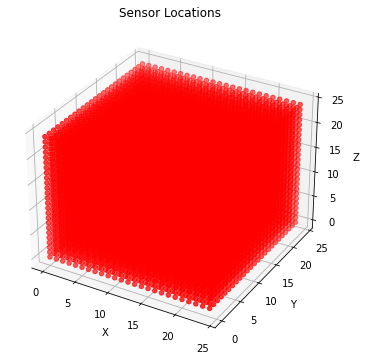

In [14]:
# Set the seed for reproducibility
np.random.seed(0)

# Define the size of your domain
domain_size = (xsize, ysize, zsize)  # Example: xsize x ysize x zsize grid

n_strata = 25    #  5
n_sensors = n_strata * n_strata * n_strata

# Define the number of strata in each dimension
strata_size = (n_strata, n_strata, n_strata)  # Example: 15x15x15 strata

# Calculate the size of each stratum
stratum_size = (domain_size[0] // strata_size[0], domain_size[1] // strata_size[1], domain_size[2] // strata_size[2])

# Generate random sensor locations within each stratum
sensor_indices = np.array([
    (np.random.randint(i * stratum_size[0], (i + 1) * stratum_size[0]),
     np.random.randint(j * stratum_size[1], (j + 1) * stratum_size[1]),
     np.random.randint(k * stratum_size[2], (k + 1) * stratum_size[2]))
    for i in range(strata_size[0])
    for j in range(strata_size[1])
    for k in range(strata_size[2])
])

print(sensor_indices)

# Plot the sensor locations
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sensor_indices[:, 0], sensor_indices[:, 1], sensor_indices[:, 2], color='red')

ax.set_title('Sensor Locations')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [15]:
# Convert sensor_indices to a PyTorch tensor
sensor_indices = torch.tensor(sensor_indices)

# Separate the x, y, and z coordinates
x_coords = sensor_indices[:, 0]
y_coords = sensor_indices[:, 1]
z_coords = sensor_indices[:, 2]

# Use broadcasting to create a grid of indices
x_coords = x_coords[None, :, None]
y_coords = y_coords[None, :, None]
z_coords = z_coords[None, :, None]

# Index the output and observation tensors at the sensor locations
# output_at_sensors = output_tensor[:, x_coords, y_coords, z_coords].squeeze()
# obs_at_sensors = Obs_sensor_3d_array[:, x_coords, y_coords, z_coords].squeeze()

# Now, output_at_sensors and obs_at_sensors should have the shape (timesteps, n_sensors)
# print(output_at_sensors.shape)
# print(obs_at_sensors.shape)

In [17]:
print(status_t1_tensor.shape)

torch.Size([1, 1, 30, 30, 30])


In [18]:
print(output.shape)

torch.Size([1, 2, 30, 30, 30])


In [19]:
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()


# C guess
# C_guess_value = 1
# c_forward1 = torch.tensor([C_guess_value]*5, dtype=torch.float32, device=device, requires_grad=True)

C_guess_value = 2.0
c_forward1 = torch.tensor(C_guess_value, dtype=torch.float32, device=device, requires_grad=True)

# lr = 0.1
lr = 0.1

# Start a new run
# run = wandb.init(project="wave eqn - 3D - One C Value", name = "obs {}, guess {}s, timestep {} whole domain, {}*{}, lr{}, Sensors{}, mu_x{}, mu_y{}".format(C_values_list, C_guess_value, timesteps, xsize, ysize, lr, n_sensors, mu_x, mu_y))
run = wandb.init(project="wave eqn - 3D - One C Value", name = "obs {}, guess {}s, timestep {} whole domain, {}*{}, lr{}, Sensors{}, mu_x{}, mu_y{}".format(c_tensor, C_guess_value, timesteps, xsize, ysize, lr, n_sensors, mu_x, mu_y))

# Use Adam optimizer
optimizer = torch.optim.Adam([c_forward1], lr)
c_values = [c_forward1.item()]

losses = []
epochs = 300

# Move clone operation outside the loop
Obs_sensor_3d_array = Status_List_stacked_obs.clone()

# Define a single model
model = AI4WaveNeuralNetwork_One_Skipping_3D(xsize, ysize, zsize, filter_weight)

for n in range(epochs):
    if n % 100 == 0:  # Print every 100 epochs
        print('epochs:', n)
    optimizer.zero_grad()
    # Forward pass through the model
    output_list = [status_t0_tensor, status_t1_tensor]
    input1 = status_t1_tensor
    input2 = status_t0_tensor
    for _ in range(timesteps):
        output = model(input1, input2, c_forward1)
        output_list.append(output[:,1:, :, :, :])
        input1 = output[:,1:, :, :, :]
        input2 = output[:,0:1, :, :, :]

    # Concatenate the output list along the time dimension
    output_tensor = torch.cat(output_list, dim=1).squeeze(0)

    # Index the output and observation tensors at the sensor locations
    output_at_sensors = output_tensor[:, x_coords, y_coords, z_coords].squeeze()
    obs_at_sensors = Obs_sensor_3d_array[:, x_coords, y_coords, z_coords].squeeze()

    # Compute the loss
    loss = mse_loss(output_at_sensors, obs_at_sensors)
    # loss = mae_loss(output_tensor, Obs_sensor_3d_array)
    # loss = torch.sqrt(torch.sum((output_tensor - Obs_sensor_3d_array) ** 2))

    # Backward pass to calculate gradients
    loss.backward(retain_graph=True)

    losses.append(loss.item())

    # optimize C
    optimizer.step()
    c_values.append(c_forward1.item())

    # Log the loss and c_value to wandb
    log_dict = {"loss": loss.item()}
    # log_dict.update({f"c_value_{i + 1}": value for i, value in enumerate(c_forward1.tolist())})
    log_dict.update({"c_value": c_values[-2]})
    wandb.log(log_dict)

plt.figure()
plt.plot(losses)
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(c_values)
plt.title('c_values over epochs')
plt.xlabel('Epoch')
plt.ylabel('c_value')
plt.show()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: guodh5 (guodh). Use `wandb login --relogin` to force relogin
2024-03-25 17:23:59.688890: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


epochs: 0
epochs: 100


KeyboardInterrupt: 

In [20]:
print(c_forward1)
print(c_values[-1])

tensor(5.9996, device='cuda:0', requires_grad=True)
5.9995903968811035
